# Demo Run

In [1]:
# %load_ext autoreload
# %autoreload 2
# # this may cause DisentenglementTargetManager to reimported, losing all the data e.g. configurations.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [3]:
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import torch
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).resolve().parents[0]))

import tardis

local_run = True
if local_run:
    tardis.config = tardis.config_local
else:
    tardis.config = tardis.config_server
# print(f"CUDA used: {torch.cuda.is_available()}")

In [4]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_subset_age_sex_1.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.shape

(27159, 2048)

In [5]:
sc.pp.filter_cells(adata, min_genes=10, inplace=True)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.shape

(27033, 2048)

In [6]:
disentenglement_targets_configurations=[
    dict(
        obs_key = "age",
        n_reserved_latent = 4,
        counteractive_minibatch_settings = dict(
            method = "random",
            method_kwargs = dict(
                within_labels = False,
                within_batch = False,
                within_categorical_covs = None,
                seed = "forward",
            )
        ),
        auxillary_losses = [  # add unlimited loss
            dict(
                apply = True, 
                progress_bar = False,
                weight = 30,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                progress_bar = True,
                weight = 0.5, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                progress_bar = True, 
                weight = 0.5, 
                method = "mse_z", 
                latent_group = "unreserved",
                counteractive_example = "negative",
                transformation = "none",
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                progress_bar = False, 
                weight = 30, 
                method = "mse_z", 
                latent_group = "unreserved",
                counteractive_example = "positive",
                transformation = "inverse",
                method_kwargs = {}
            ),
        ]
    )
]

model_params = dict(
    n_hidden=256,
    n_layers=4, 
    n_latent=24, 
    gene_likelihood="nb",
    dropout_rate = 0.1,
    include_auxillary_loss = True
)

train_params = dict(
    max_epochs=400,
    train_size=0.9,
    batch_size=512,
    check_val_every_n_epoch=10,
    plan_kwargs = dict(
        n_epochs_kl_warmup=100,
        # weight_decay=1e-3,
        # optimizer="AdamW"
    )
)

dataset_params = dict(
    layer=None, 
    labels_key="cell_type",
    batch_key="concatenated_integration_covariates",
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations
)

tardis.MyModel.setup_anndata(adata, **dataset_params)

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(adata, **model_params)
vae.train(**train_params)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/Users/kemalinecik/git_nosync/tardis/tardis/_counteractiveminibatchgenerator.py:61: UserWarning: Possible group definition indices are calculating for `age` for `training` set.
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/Users/kemalinecik/git_nosync/tardis/tardis/_counteractiveminibatchgenerator.py:61: UserWarning: Number of elements in each group for `age` in `training` set: 10265,4936,9129
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 10/400:   2%|▏         | 9/400 [00:36<26:05,  4.00s/it, v_num=1, total_loss_train=231, kl_local_train=17.4, tardis_age_1_train=1.71, tardis_age_2_train=1.23]

/Users/kemalinecik/git_nosync/tardis/tardis/_counteractiveminibatchgenerator.py:61: UserWarning: Possible group definition indices are calculating for `age` for `validation` set.
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/Users/kemalinecik/git_nosync/tardis/tardis/_counteractiveminibatchgenerator.py:61: UserWarning: Number of elements in each group for `age` in `validation` set: 1177,555,971
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 138/400:  34%|███▍      | 137/400 [09:40<18:41,  4.26s/it, v_num=1, total_loss_train=241, kl_local_train=8.36, tardis_age_1_train=1.67, tardis_age_2_train=1.25]

/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


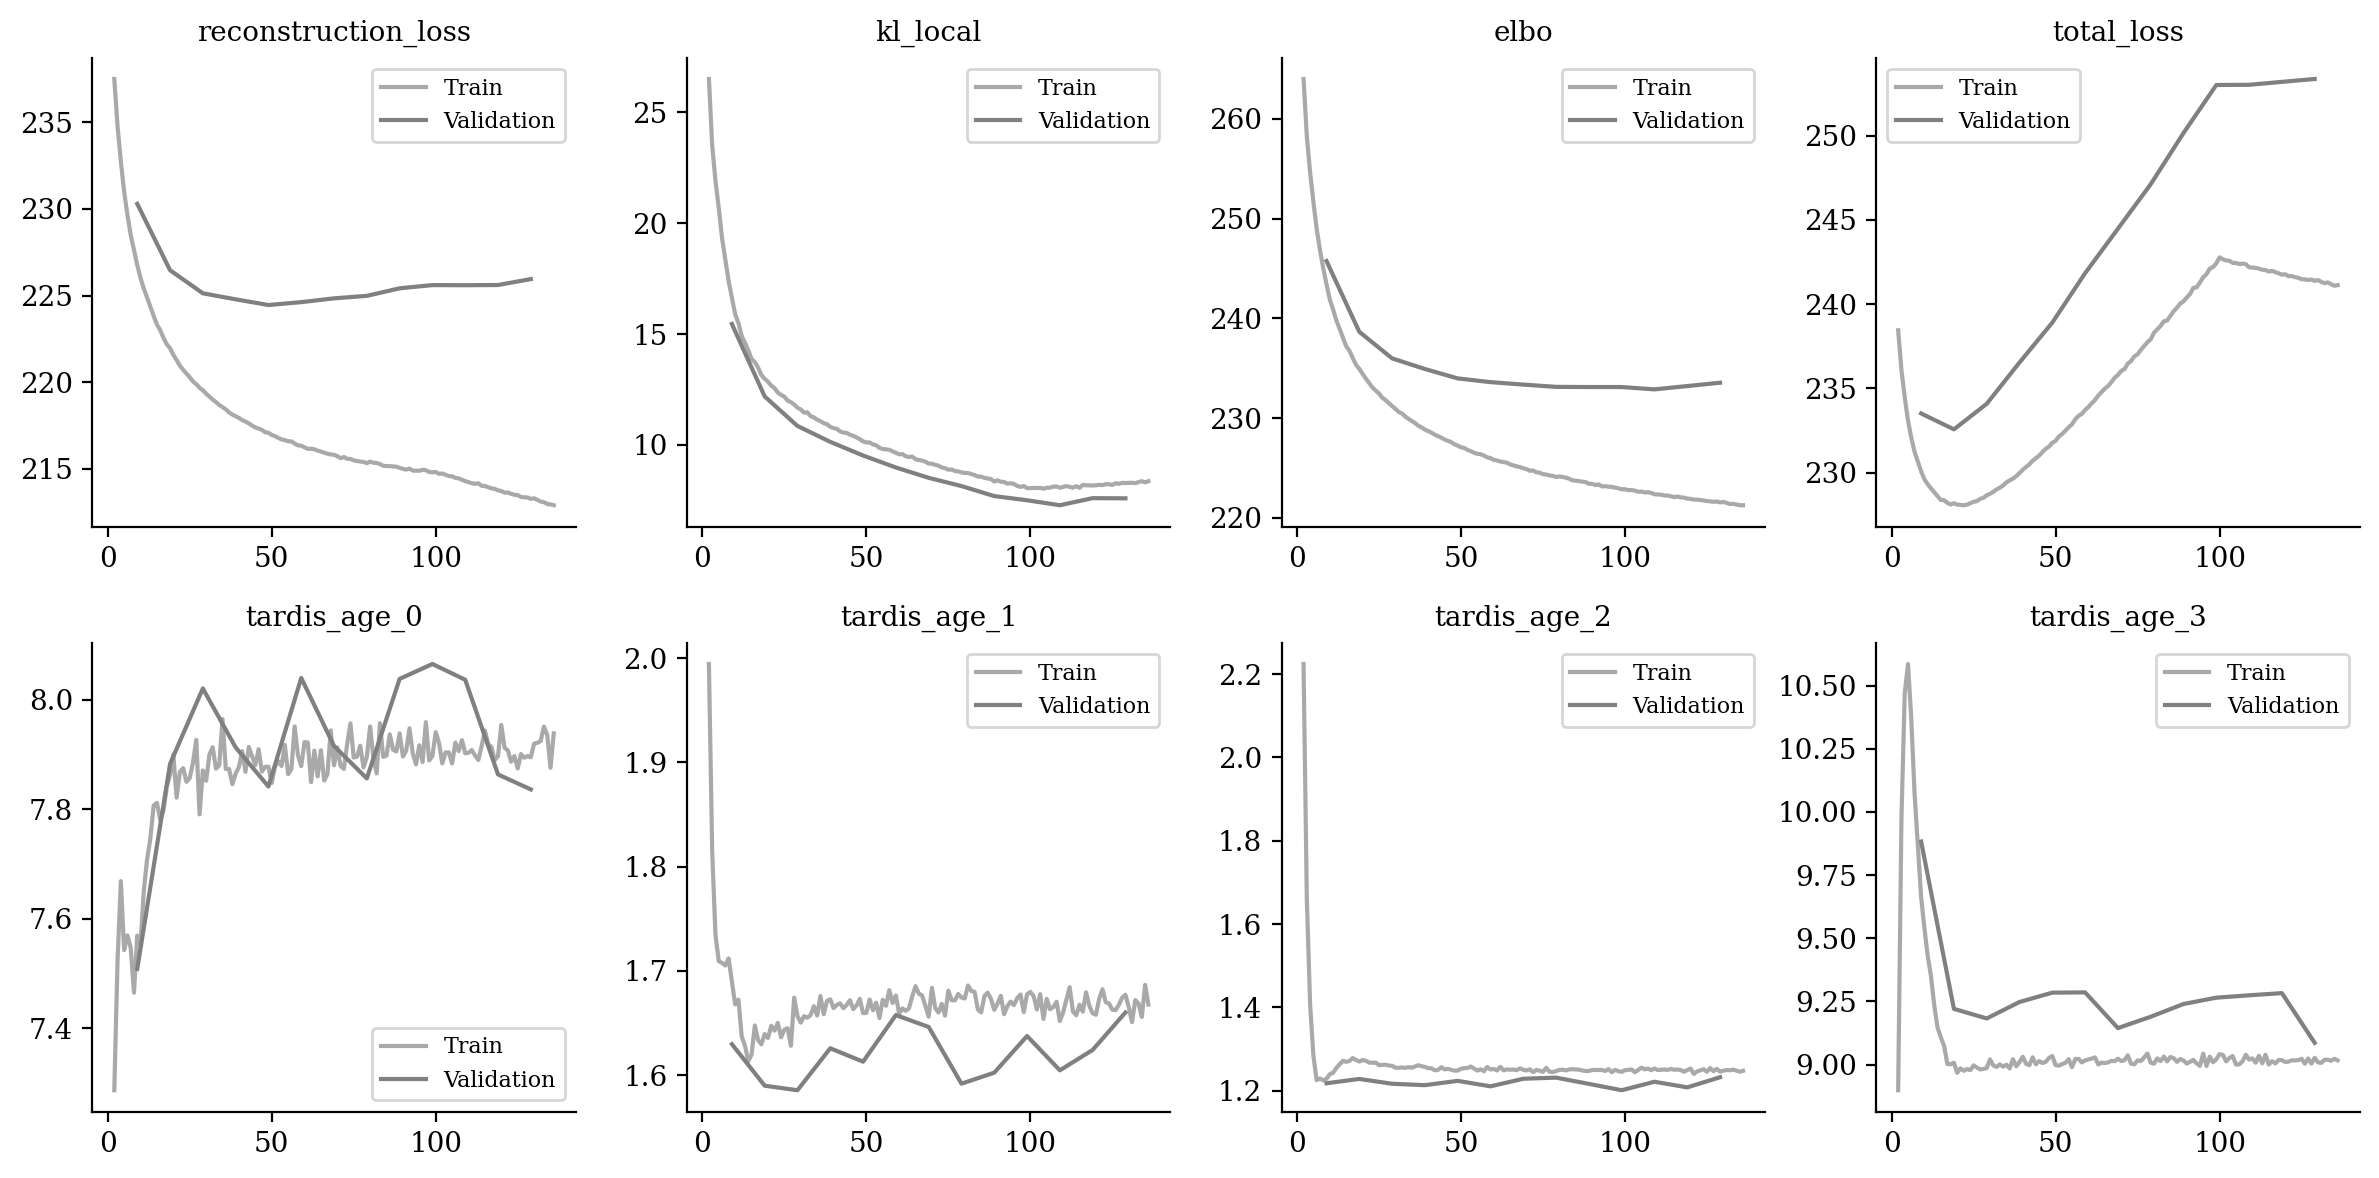

In [10]:
vae.plot_training_history(
    ignore_first=2, 
    n_col=4,
    metrics_name=[
        "reconstruction_loss", "kl_local", "elbo", "total_loss",
        "tardis_age_0", 
        "tardis_age_1",
        "tardis_age_2",
        "tardis_age_3"
    ]
)

In [8]:
from tardis._disentenglementtargetmanager import DisentenglementTargetManager
DisentenglementTargetManager.configurations.get_by_obs_key("age").reserved_latent_indices

[0, 1, 2, 3]

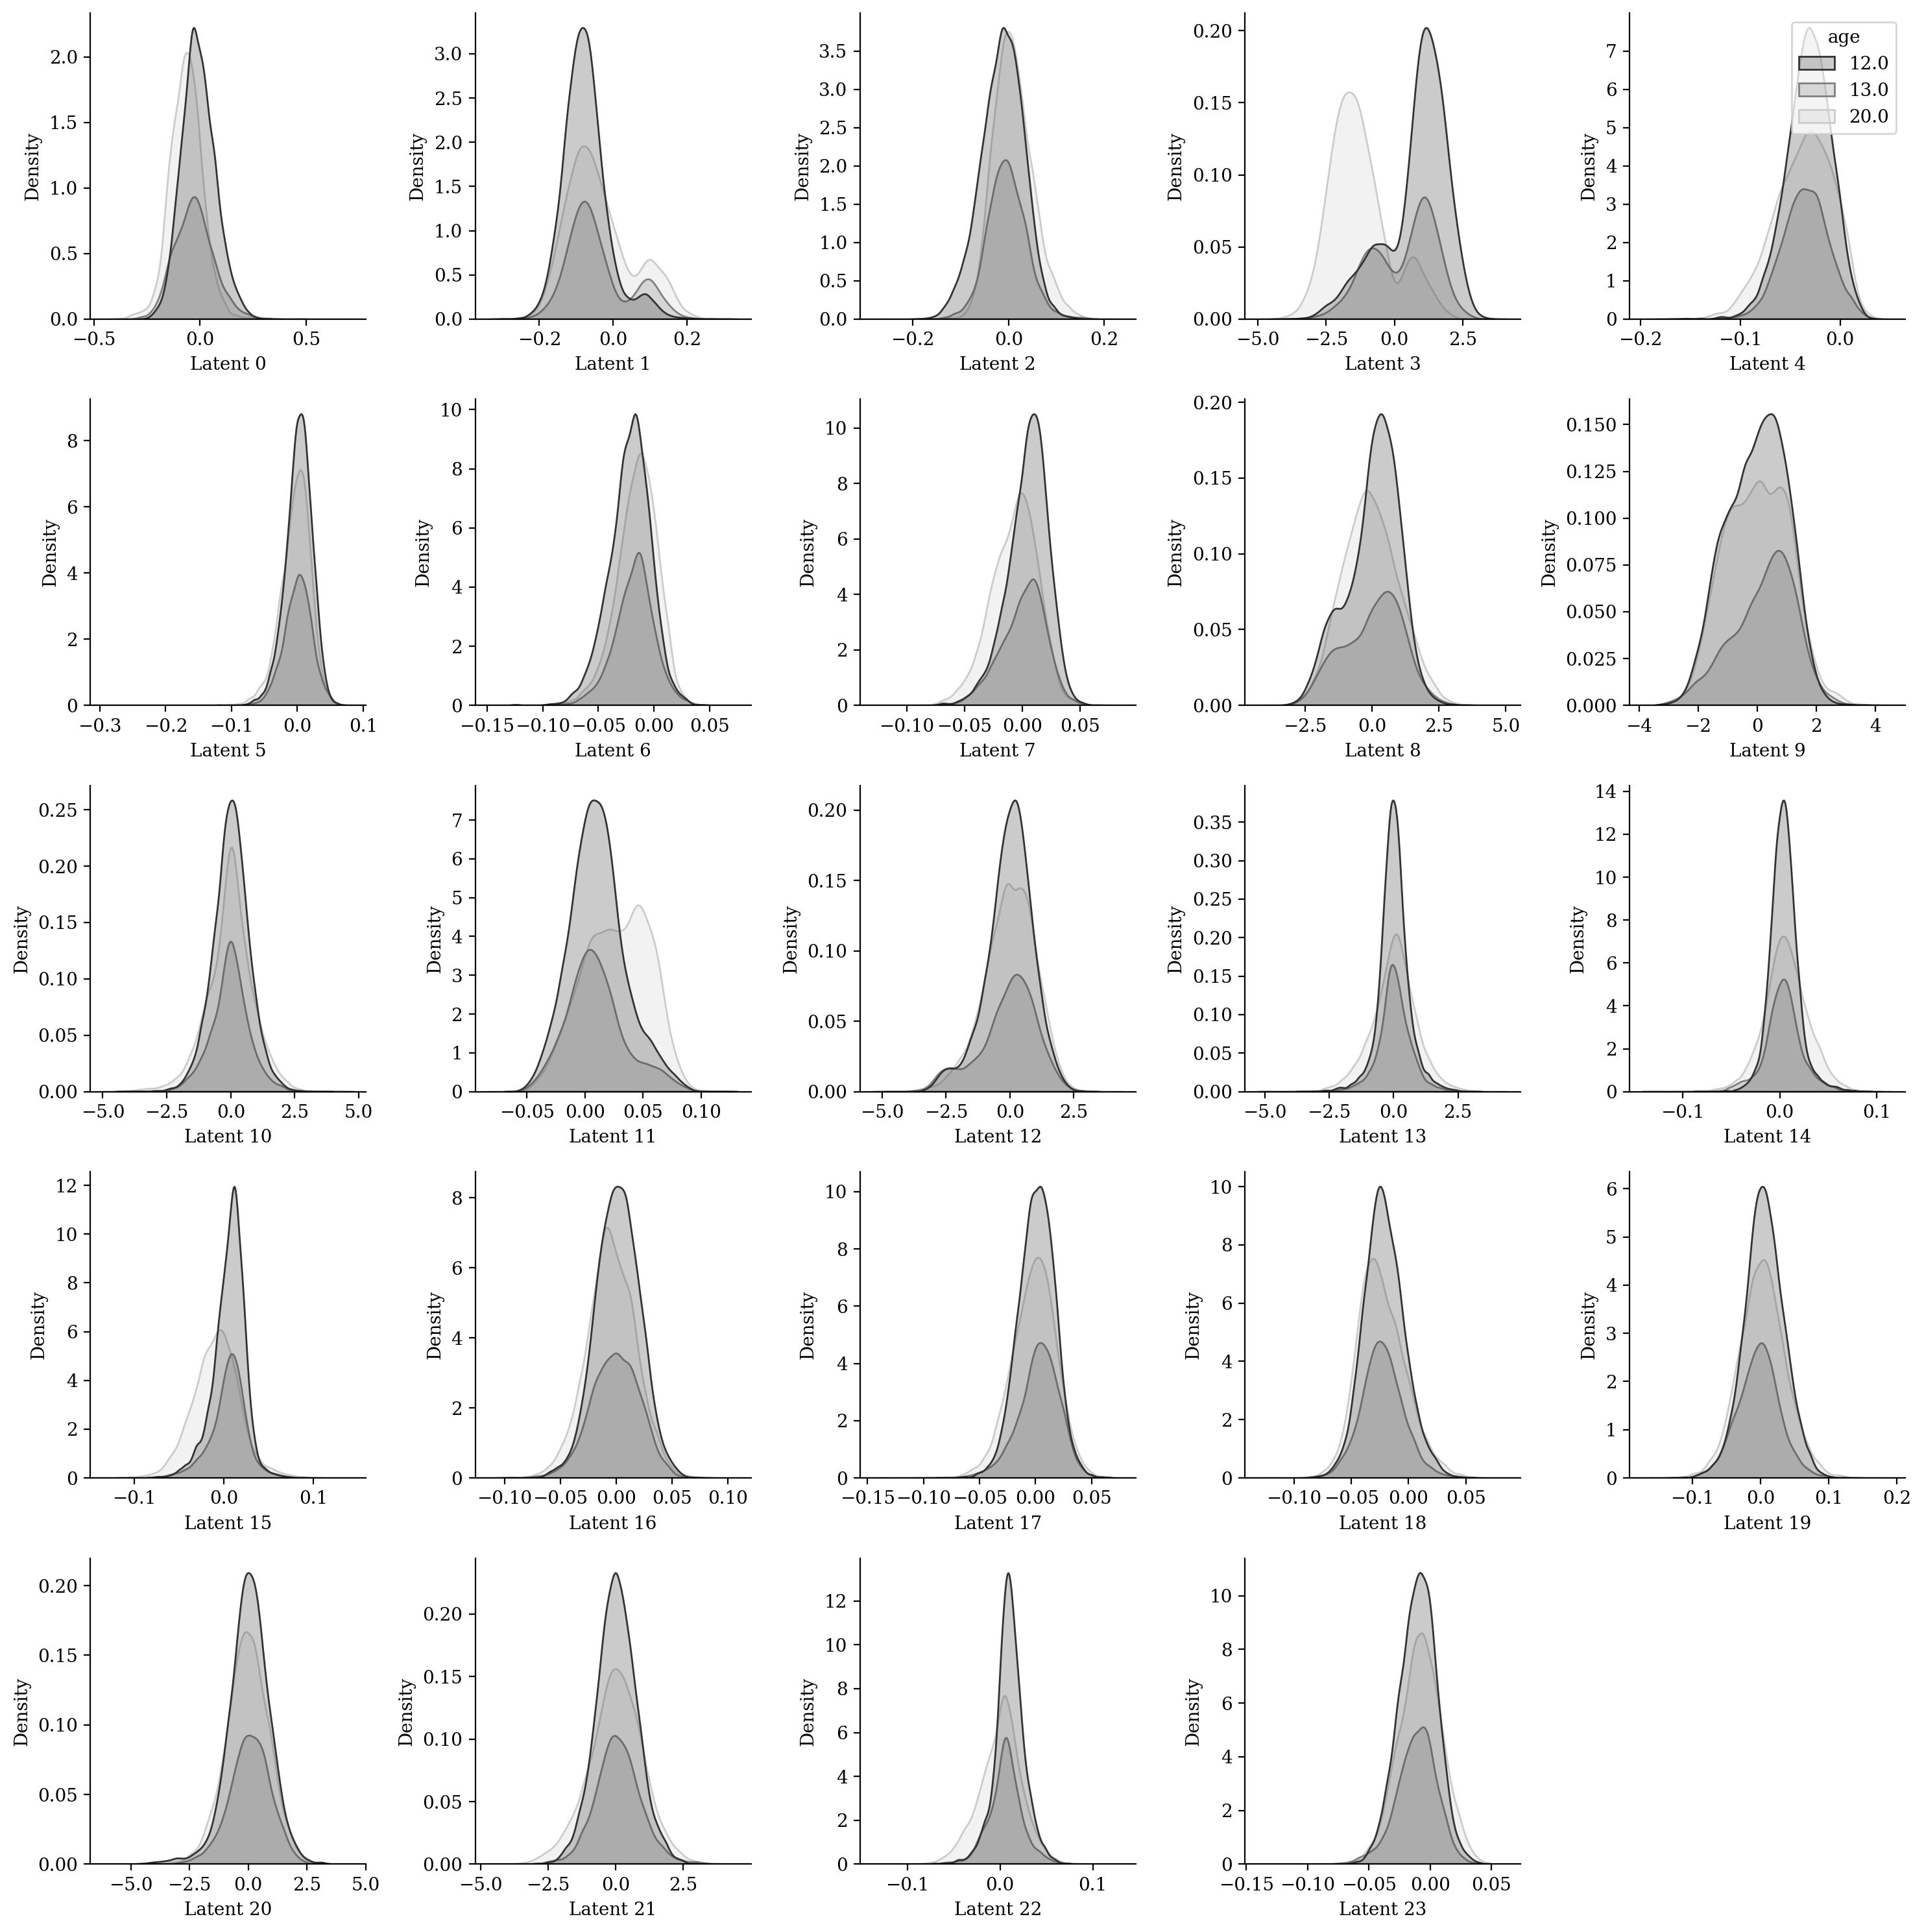

In [9]:
vae.plot_latent_kde(
    adata_obs=adata.obs,
    target_obs_key="age",
    latent_representation=vae.get_latent_representation(),
    latent_dim_of_interest=None
)

# Playground

# Visualization

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent, min_dist=0.2)
display(latent.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "cell_type", "concatenated_integration_covariates"], 
        ncols=3,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )
    
del latent
gc.collect();

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
for cell_type in latent.obs["cell_type"].unique():
    _latent = latent[latent.obs["cell_type"] == cell_type].copy()
    sc.pp.neighbors(_latent, n_neighbors = 30)
    sc.tl.umap(_latent, min_dist=0.2)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sc.pl.umap(
            _latent, 
            color=["age", "concatenated_integration_covariates"], 
            ncols=3,
            frameon=False,
            title=cell_type,
            legend_fontsize="xx-small"
        )
    del _latent
    gc.collect();

del latent
gc.collect();

In [ ]:
from tardis._disentenglementtargetmanager import DisentenglementTargetManager
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.get_by_obs_key("age").unreserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent, min_dist=0.2)
display(latent.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "cell_type", "concatenated_integration_covariates"], 
        ncols=2,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )

del latent
gc.collect();

In [ ]:
from tardis._disentenglementtargetmanager import DisentenglementTargetManager
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent, min_dist=0.2)
display(latent.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "cell_type", "concatenated_integration_covariates"], 
        ncols=2,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )

del latent
gc.collect();

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.get_by_obs_key("age").unreserved_latent_indices], obs=adata.obs.copy())
for cell_type in latent.obs["cell_type"].unique():
    _latent = latent[latent.obs["cell_type"] == cell_type].copy()
    sc.pp.neighbors(_latent, n_neighbors = 30)
    sc.tl.umap(_latent, min_dist=0.2)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sc.pl.umap(
            _latent, 
            color=["age", "concatenated_integration_covariates"], 
            ncols=3,
            frameon=False,
            title=cell_type,
            legend_fontsize="xx-small"
        )
    del _latent
    gc.collect();
    
del latent
gc.collect();